In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statistics
from scipy.stats import mannwhitneyu
from bs4 import BeautifulSoup  
import requests
import string
import pymorphy2
import dask.bag as db
from datetime import datetime
from sklearn.model_selection import train_test_split

# Задача: построить модель количество визитов в больницу
### Загружаем данные

In [4]:
item = 'OFP' # Выбрать из поля Item для вашего датасета
package = 'Ecdat' # Выбрать из поля Package для вашего датасета

df = sm.datasets.get_rdataset(item, package , cache=True).data
df.head()

,ofp,ofnp,opp,opnp,emr,hosp,numchron,adldiff,age,black,sex,maried,school,faminc,employed,privins,medicaid,region,hlth
0,5,0,0,0,0,1,2,0,6.9,yes,male,yes,6,2.8810,yes,yes,no,other,other
1,1,0,2,0,2,0,2,0,7.4,no,female,yes,10,2.7478,no,yes,no,other,other
2,13,0,0,0,3,3,4,1,6.6,yes,female,no,10,0.6532,no,no,yes,other,poor
3,16,0,5,0,1,1,2,1,7.6,no,male,yes,3,0.6588,no,yes,no,other,poor
4,3,0,0,0,0,0,2,1,7.9,no,female,yes,6,0.6588,no,yes,no,other,other


### Вводим новую переменную количество визитов в больницу

In [7]:
df['hosp_v'] = df['ofp'] + df['opp'] + df['opnp'] + df['ofnp'] + df['emr'] + df['hosp']

### Приводим возраст в надлежащий вид (в датасете они разделены на 10)

In [10]:
df['age'] = df['age']*10
df['age'] = df['age'].round().astype(int)

### Просмотрим структуру нашего df и определим есть ли пропуски

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4406 entries, 0 to 4405
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ofp       4406 non-null   int64  
 1   ofnp      4406 non-null   int64  
 2   opp       4406 non-null   int64  
 3   opnp      4406 non-null   int64  
 4   emr       4406 non-null   int64  
 5   hosp      4406 non-null   int64  
 6   numchron  4406 non-null   int64  
 7   adldiff   4406 non-null   int64  
 8   age       4406 non-null   int32  
 9   black     4406 non-null   object 
 10  sex       4406 non-null   object 
 11  maried    4406 non-null   object 
 12  school    4406 non-null   int64  
 13  faminc    4406 non-null   float64
 14  employed  4406 non-null   object 
 15  privins   4406 non-null   object 
 16  medicaid  4406 non-null   object 
 17  region    4406 non-null   object 
 18  hlth      4406 non-null   object 
 19  hosp_v    4406 non-null   int64  
dtypes: float64(1), int32(1), int64

In [15]:
# Пропусков нет.

### Заменяем категориальные переменные 0 и 1

In [18]:
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'male' else 0)
df['black'] = df['black'].apply(lambda x: 1 if x == 'yes' else 0)
df['maried'] = df['maried'].apply(lambda x: 1 if x == 'yes' else 0)
df['employed'] = df['employed'].apply(lambda x: 1 if x == 'yes' else 0)
df['privins'] = df['privins'].apply(lambda x: 1 if x == 'yes' else 0)
df['medicaid'] = df['medicaid'].apply(lambda x: 1 if x == 'yes' else 0)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4406 entries, 0 to 4405
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ofp       4406 non-null   int64  
 1   ofnp      4406 non-null   int64  
 2   opp       4406 non-null   int64  
 3   opnp      4406 non-null   int64  
 4   emr       4406 non-null   int64  
 5   hosp      4406 non-null   int64  
 6   numchron  4406 non-null   int64  
 7   adldiff   4406 non-null   int64  
 8   age       4406 non-null   int32  
 9   black     4406 non-null   int64  
 10  sex       4406 non-null   int64  
 11  maried    4406 non-null   int64  
 12  school    4406 non-null   int64  
 13  faminc    4406 non-null   float64
 14  employed  4406 non-null   int64  
 15  privins   4406 non-null   int64  
 16  medicaid  4406 non-null   int64  
 17  region    4406 non-null   object 
 18  hlth      4406 non-null   object 
 19  hosp_v    4406 non-null   int64  
dtypes: float64(1), int32(1), int64

In [22]:
df

,ofp,ofnp,opp,opnp,emr,hosp,numchron,adldiff,age,black,sex,maried,school,faminc,employed,privins,medicaid,region,hlth,hosp_v
0,5,0,0,0,0,1,2,0,69,1,1,1,6,2.881000,1,1,0,other,other,6
1,1,0,2,0,2,0,2,0,74,0,0,1,10,2.747800,0,1,0,other,other,5
2,13,0,0,0,3,3,4,1,66,1,0,0,10,0.653200,0,0,1,other,poor,19
3,16,0,5,0,1,1,2,1,76,0,1,1,3,0.658800,0,1,0,other,poor,23
4,3,0,0,0,0,0,2,1,79,0,0,1,6,0.658800,0,1,0,other,other,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4401,11,0,0,0,0,0,0,0,84,0,0,1,8,2.249700,0,1,0,other,other,11
4402,12,0,0,0,0,0,2,0,78,0,0,0,11,5.813200,0,1,0,other,other,12
4403,10,0,20,0,1,1,5,0,73,0,1,1,12,3.877916,0,1,0,other,other,32
4404,16,1,0,0,0,0,0,0,66,0,0,1,12,3.877916,0,1,0,other,other,17


In [24]:
#cat_hos = ['adldiff', 'black', 'sex', 'maried', 'employed', 'privins', 'medicaid']
#num_hos = ['numchron', 'age', 'school', 'faminc']
#target_hos = ['hosp_v']

cat_hos = ['employed']
num_hos = ['numchron','school', 'faminc']
target_hos = ['hosp_v']



### Посмотрим на распределение целевой переменной

array([[<Axes: title={'center': 'hosp_v'}>]], dtype=object)

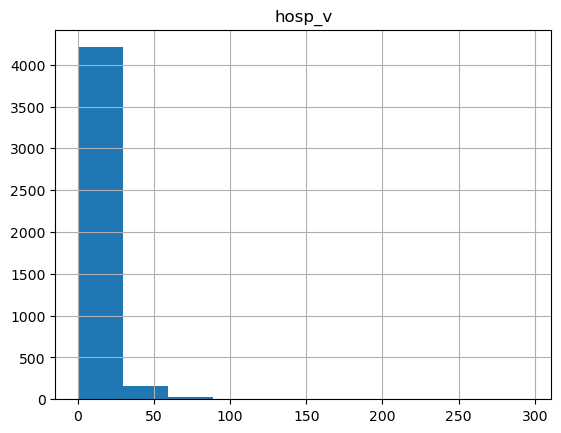

In [27]:
df[target_hos].hist()

### Обучим модель без учета выбросов

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[cat_hos + num_hos], df[target_hos], test_size = 0.4, random_state = 42)

In [32]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

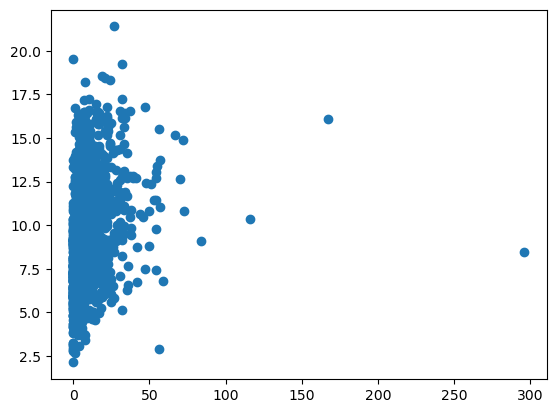

In [34]:
y_pred = ols.predict(X_test)
plt.scatter(y_test, y_pred)
plt.show()

In [36]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print('R2', r2_score(y_test, y_pred))
print('MAE', mean_absolute_error(y_test, y_pred))
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAPE', mean_absolute_percentage_error(y_test, y_pred))

R2 0.06442685163766082
MAE 6.644044058564956
RMSE 12.238341243803005
MAPE 3192885128561175.5


### Убираем выбросы

In [39]:
df['hosp_v'].describe()

count    4406.000000
mean        9.238765
std        12.198796
min         0.000000
25%         2.000000
50%         6.000000
75%        12.000000
max       296.000000
Name: hosp_v, dtype: float64

In [41]:
q1 = df['hosp_v'].quantile(0.25)
q3 = df['hosp_v'].quantile(0.75)
iqr = q3 - q1
df = df[(df['hosp_v']>=q1 - 1.5*iqr)&(df['hosp_v']<=q1 + 1.5*iqr)]

In [43]:
df['hosp_v'].describe()

count    3821.000000
mean        5.909710
std         4.611784
min         0.000000
25%         2.000000
50%         5.000000
75%         9.000000
max        17.000000
Name: hosp_v, dtype: float64

array([[<Axes: title={'center': 'hosp_v'}>]], dtype=object)

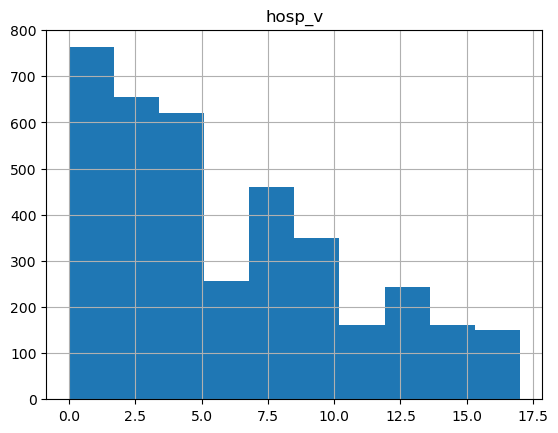

In [45]:
df[target_hos].hist()

### Обучаем задачу классификации

In [48]:
y_clf = np.where(df[target_hos] == 0, 0, 1)
X_clf = df[num_hos + cat_hos]

### Делим выборку на обучающую, тестовую и прогнозную

In [51]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size = 0.4, random_state = 42)

#### Обучим модель логистической регрессии

In [54]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(random_state=0).fit(X_train_clf, y_train_clf)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [56]:
y_pred_clf = logit.predict(X_test_clf)

In [58]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test_clf, y_pred_clf), index = ['True 0', 'True 1'], columns = ['Pred 0', 'Pred 1'])

,Pred 0,Pred 1
True 0,0,174
True 1,0,1355


In [60]:
from sklearn.metrics import precision_score, recall_score
print('Precision', precision_score(y_test_clf, y_pred_clf))
print('Recall', recall_score(y_test_clf, y_pred_clf))

Precision 0.8862001308044474
Recall 1.0


### Обучаем задачу регрессии

#### Оставляем в выборке только те посещения, где есть ненулевые убийства

In [64]:
data_nonnull = df[df['hosp_v']>0]

#### Linear Regression (OLS)

In [67]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(data_nonnull[cat_hos + num_hos], data_nonnull[target_hos], test_size = 0.4, random_state = 42)

In [69]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train_reg, y_train_reg)

LinearRegression()

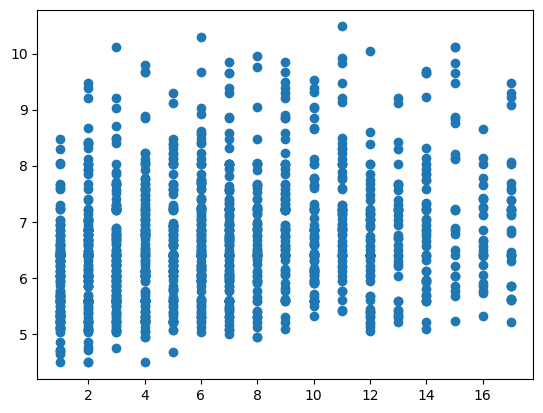

In [71]:
y_pred_reg = ols.predict(X_test_reg)
plt.scatter(y_test_reg, y_pred_reg)
plt.show()

### Метрики качества модели регрессии

In [74]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print('R2', r2_score(y_test_reg, y_pred_reg))
print('MAE', mean_absolute_error(y_test_reg, y_pred_reg))
print('RMSE', np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))
print('MAPE', mean_absolute_percentage_error(y_test_reg, y_pred_reg))

R2 0.059401169584971214
MAE 3.469812480388125
RMSE 4.224732860731292
MAPE 1.0442328687017304


In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[cat_hos + num_hos], df[target_hos], test_size = 0.4, random_state = 42)

In [45]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

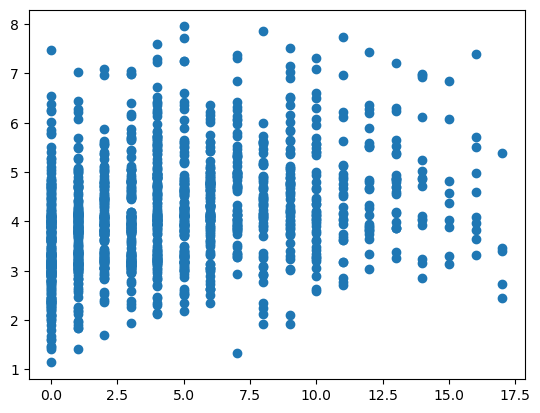

In [47]:
y_pred = ols.predict(X_test)
plt.scatter(y_test, y_pred)
plt.show()

In [51]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print('R2', r2_score(y_test, y_pred))
print('MAE', mean_absolute_error(y_test, y_pred))
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAPE', mean_absolute_percentage_error(y_test, y_pred))

R2 0.09687390266175466
MAE 2.82801527112674
RMSE 3.6153218369013214
MAPE 2804855452391009.5


In [ ]:
print('R2', r2_score(test_df['ofp'], test_data['pred_murder']))
print('MAE', mean_absolute_error(test_data['murdrate'], test_data['pred_murder']))
print('RMSE', np.sqrt(mean_squared_error(test_data['murdrate'], test_data['pred_murder'])))
print('MAPE', mean_absolute_percentage_error(test_data['murdrate'], test_data['pred_murder']))

### Обучаем задачу классификации

In [84]:
y_clf = np.where(df[target_hos] == 0, 0, 1)
X_clf = df[num_hos + cat_hos]

### Делим выборку на обучающую, тестовую и прогнозную

In [87]:
from sklearn.model_selection import train_test_split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size = 0.4, random_state = 42)

In [89]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train_clf, y_train_clf)

LinearRegression()

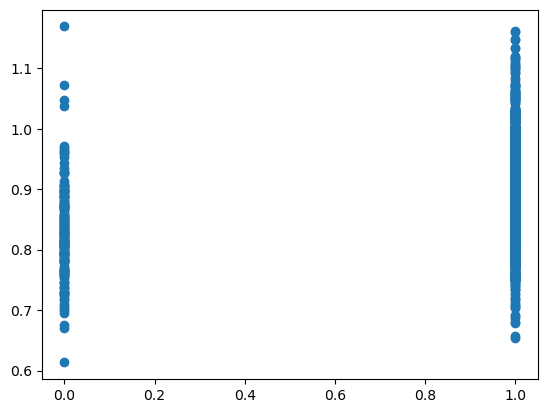

In [91]:
y_pred = ols.predict(X_test_clf)
plt.scatter(y_test_clf, y_pred)
plt.show()

In [93]:
### ---------------------------

In [95]:
X_train_clf.shape

(2292, 11)

In [97]:
X_test_clf.shape

(1529, 11)

In [99]:
X_test_clf, X_forecast, y_test_clf, y_forecast = train_test_split(X_test_clf, y_test_clf, test_size = 0.5, random_state = 42)

In [101]:
X_test_clf.shape

(764, 11)

In [103]:
X_forecast.shape

(765, 11)

#### Обучим модель логистической регрессии

In [106]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(random_state=0).fit(X_train_clf, y_train_clf)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [108]:
y_pred_clf = logit.predict(X_test_clf)

In [110]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test_clf, y_pred_clf), index = ['True 0', 'True 1'], columns = ['Pred 0', 'Pred 1'])

,Pred 0,Pred 1
True 0,1,92
True 1,1,670


In [112]:
from sklearn.metrics import precision_score, recall_score
print('Precision', precision_score(y_test_clf, y_pred_clf))
print('Recall', recall_score(y_test_clf, y_pred_clf))

Precision 0.8792650918635171
Recall 0.9985096870342772


In [114]:
### Обучаем задачу регрессии

In [ ]:
#data_nonnull = data[data['murdrate']>0]

In [ ]:
#### Linear Regression (OLS)